In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub


In [2]:
train_d, val_ds, test_ds = tfds.load('imdb_reviews', split=('train[:60%]','train[60%:]', 'test'),
                         as_supervised=True)


In [3]:
train_example_batch, train_label_batch = next(iter(train_d.batch(10)))
train_example_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [4]:
train_label_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)>

## Taking layer for embedding that use pretrained model embedding

In [14]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim128/2'
hub_layer = hub.KerasLayer(embedding, input_shape = [],
                          dtype=tf.string, trainable=True)
hub_layer(train_example_batch[:3])

<tf.Tensor: shape=(3, 128), dtype=float32, numpy=
array([[ 9.01966274e-01, -4.83913347e-03,  1.17907055e-01,
         3.81319046e-01,  6.57222793e-02, -3.01581532e-01,
         8.90584365e-02, -2.69034863e-01, -8.51345584e-02,
         1.08877886e-02, -6.66372627e-02, -3.73063087e-01,
        -2.76447266e-01, -1.87254980e-01,  5.67507632e-02,
         9.09779966e-02, -6.24961555e-02, -3.28687276e-03,
        -3.08512092e-01,  3.78482223e-01,  7.62880966e-02,
         1.43733576e-01, -1.12897493e-01,  9.59761534e-03,
        -2.38938913e-01,  2.93743908e-02,  7.28663057e-02,
        -2.48727947e-02, -8.16893280e-02,  6.68320432e-02,
        -5.62225394e-02,  2.47078985e-01,  1.17681175e-01,
         3.17581035e-02,  2.65932620e-01, -1.37706831e-01,
        -1.50708258e-01, -1.63614675e-01, -1.51269153e-01,
         2.34616160e-01, -9.12236273e-02, -4.22684886e-02,
        -1.01224177e-01, -2.12229744e-01,  6.74503446e-02,
         1.85163647e-01,  3.62982228e-02, -3.50210071e-01,
      

In [15]:
# Building Model
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
             loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]

In [18]:
history = model.fit(train_d.shuffle(10000).batch(512),
                   epochs=10,
                   validation_data=val_ds.batch(512),
                   verbose=1,
                   callbacks=callbacks)

Epoch 1/10
30/30 [==============================] - 110s 4s/step - loss: 0.6164 - accuracy: 0.5838 - val_loss: 0.5288 - val_accuracy: 0.7126
Epoch 2/10
30/30 [==============================] - 112s 4s/step - loss: 0.4253 - accuracy: 0.8068 - val_loss: 0.3881 - val_accuracy: 0.8324
Epoch 3/10
30/30 [==============================] - 118s 4s/step - loss: 0.2777 - accuracy: 0.8933 - val_loss: 0.3251 - val_accuracy: 0.8624
Epoch 4/10
30/30 [==============================] - 120s 4s/step - loss: 0.1846 - accuracy: 0.9387 - val_loss: 0.3014 - val_accuracy: 0.8687
Epoch 5/10
30/30 [==============================] - 128s 4s/step - loss: 0.1224 - accuracy: 0.9648 - val_loss: 0.2977 - val_accuracy: 0.8734
Epoch 6/10
30/30 [==============================] - 117s 4s/step - loss: 0.0789 - accuracy: 0.9823 - val_loss: 0.3079 - val_accuracy: 0.8778
Epoch 6: early stopping


In [19]:
#Evaluate
test_loss, test_acc = model.evaluate(test_ds.batch(512), verbose=2)

print('test loss: ', test_loss)
print('test acc: ', test_acc)

49/49 - 16s - loss: 0.3251 - accuracy: 0.8624 - 16s/epoch - 326ms/step
test loss:  0.32505813241004944
test acc:  0.8623999953269958


In [20]:
# Importing matplotlib and creating helper func to plot graphs
import matplotlib.pyplot as plt

def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], "")
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.643316687643528)

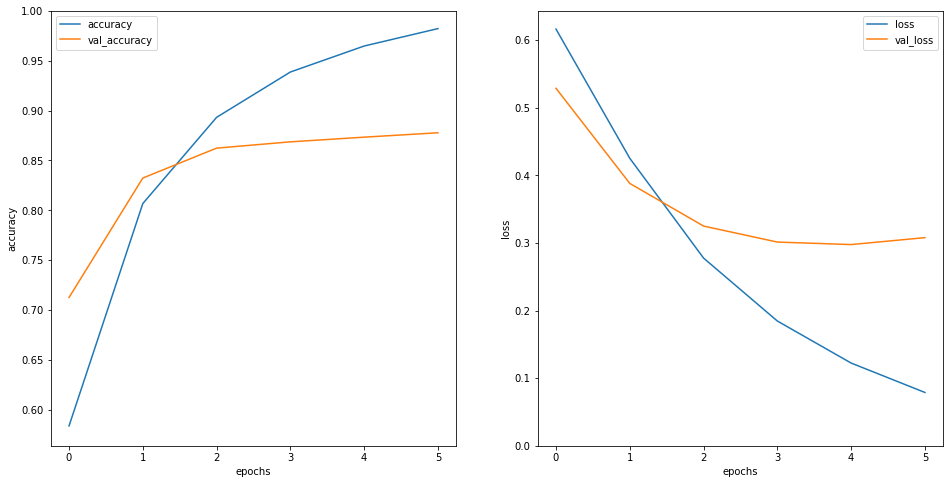

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graph(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graph(history, 'loss')
plt.ylim(0, None)

In [22]:
## Prediction
sample_text = ('This movie was cool. The animation and graphics were out of this world. I would recommend this movie')
prediction = model.predict(np.array([sample_text]))

1/1 [==============================] - 1s 1s/step


In [23]:
print(prediction)

[[1.1868596]]


In [24]:

sample_text = ('This movie was boring. The animation and graphics were disappointing. I would not recommend this movie')
prediction = model.predict(np.array([sample_text]))
print(prediction)

1/1 [==============================] - 0s 305ms/step
[[-2.0169902]]


In [26]:

sample_text = ('waste of money')
prediction = model.predict(np.array([sample_text]))
print(prediction)

1/1 [==============================] - 0s 291ms/step
[[-5.6592226]]
